In [22]:
import matplotlib.pyplot as plt
import tensorflow as tf
import json
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
import pandas as pd
from tensorflow.keras import Model,callbacks,optimizers
from tensorflow.keras.layers import Dense,Dropout,Embedding,Input,LSTM
from sklearn.metrics import classification_report,confusion_matrix


In [ ]:
import os

base_dir=os.path.abspath(".")
data_dir=os.path.join(base_dir,"data","processed")
model_dir=os.path.join(data_dir,"models")
train_csv=os.path.join(data_dir,"train.csv")
val_csv=os.path.join(data_dir,"val.csv")

test_csv=os.path.join(data_dir,"test.csv")
mapping_path=os.path.join(data_dir,"label_mapping.json")

os.makedirs(model_dir,exist_ok=True)

model_dir

In [ ]:
train_df=pd.read_csv(train_csv)
val_df=pd.read_csv(val_csv)
test_df=pd.read_csv(test_csv)
with open(mapping_path,"r",encoding="utf-8") as f:
    mappng=json.load(f)
id_to_lbl={int(k):v for k,v in mappng["id_to_label"].items()}
train_df.head(3)

,clean_text,label,label_id
0,i didnt feel humiliated,sadness,4
1,i can go from feeling so hopeless to so damned...,sadness,4
2,im grabbing a minute to post i feel greedy wrong,anger,0


voc 


In [ ]:
tok=Tokenizer(oov_token="<unk>")
tok.fit_on_texts(train_df["clean_text"].astype(str).tolist())
train_seq=tok.texts_to_sequences(train_df["clean_text"].astype(str).tolist())
val_seq=tok.texts_to_sequences(val_df["clean_text"].astype(str).tolist())
test_seq=tok.texts_to_sequences(test_df["clean_text"].astype(str).tolist())

x_train=pad_sequences(train_seq,maxlen=64,padding="post",truncating="post")
x_val=pad_sequences(val_seq,maxlen=64,padding="post",truncating="post")
x_test=pad_sequences(test_seq,maxlen=64,padding="post",truncating="post")

y_train=train_df["label_id"].values
y_val=val_df["label_id"].values
y_test=test_df["label_id"].values

vocab_sz=len(tok.word_index)+1
vocab_sz

15214

In [ ]:
train_ds=tf.data.Dataset.from_tensor_slices((x_train,y_train)).shuffle(len(x_train),seed=42).batch(64)
val_ds=tf.data.Dataset.from_tensor_slices((x_val,y_val)).batch(64)
test_ds=tf.data.Dataset.from_tensor_slices((x_test,y_test)).batch(64)

train_ds

<_BatchDataset element_spec=(TensorSpec(shape=(None, 64), dtype=tf.int32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

## LSTM Model

In [ ]:
inp=Input(shape=(64,))
x=Embedding(vocab_sz,128,mask_zero=True)(inp)
x=LSTM(128,return_sequences=False)(x)
x=Dropout(0.3)(x)
out=Dense(len(id_to_lbl),activation="softmax")(x)

mdl=Model(inp,out)
mdl.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 64)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 64, 128)   │  1,947,392 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, 64)        │          0 │ input_layer[0][0] │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 128)       │    131,584 │ embedding[0][0],  │
│                     │                   │            │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128)       │          0 │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 6)         │        774 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,079,750 (7.93 MB)

 Trainable params: 2,079,750 (7.93 MB)

 Non-trainable params: 0 (0.00 B)

## Train LSTM 

In [ ]:
mdl.compile(
    optimizer=optimizers.Adam(learning_rate=1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)
best_pth=os.path.join(model_dir,"best_lstm.keras")
cllbacks=[
    callbacks.EarlyStopping(monitor="val_loss",patience=2,restore_best_weights=True),
    callbacks.ModelCheckpoint(best_pth,monitor="val_loss",save_best_only=True),]
hist=mdl.fit(
    train_ds,
    validation_data=val_ds,
    epochs=8,
    callbacks=cllbacks,
)

Epoch 1/8


250/250 ━━━━━━━━━━━━━━━━━━━━ 22s 80ms/step - accuracy: 0.3868 - loss: 1.5104 - val_accuracy: 0.7585 - val_loss: 0.7298
Epoch 2/8
250/250 ━━━━━━━━━━━━━━━━━━━━ 20s 80ms/step - accuracy: 0.8519 - loss: 0.4748 - val_accuracy: 0.9035 - val_loss: 0.2849
Epoch 3/8
250/250 ━━━━━━━━━━━━━━━━━━━━ 22s 86ms/step - accuracy: 0.9522 - loss: 0.1554 - val_accuracy: 0.9175 - val_loss: 0.2338
Epoch 4/8
250/250 ━━━━━━━━━━━━━━━━━━━━ 22s 87ms/step - accuracy: 0.9716 - loss: 0.0844 - val_accuracy: 0.9165 - val_loss: 0.2533
Epoch 5/8
250/250 ━━━━━━━━━━━━━━━━━━━━ 35s 141ms/step - accuracy: 0.9824 - loss: 0.0555 - val_accuracy: 0.9175 - val_loss: 0.2877


## Evaluate 

32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step
Test accuracy: 0.9120
              precision    recall  f1-score   support

       anger       0.93      0.90      0.91       275
        fear       0.86      0.85      0.86       224
         joy       0.95      0.93      0.94       695
        love       0.76      0.84      0.80       159
     sadness       0.96      0.96      0.96       581
    surprise       0.68      0.79      0.73        66

    accuracy                           0.91      2000
   macro avg       0.86      0.88      0.87      2000
weighted avg       0.91      0.91      0.91      2000



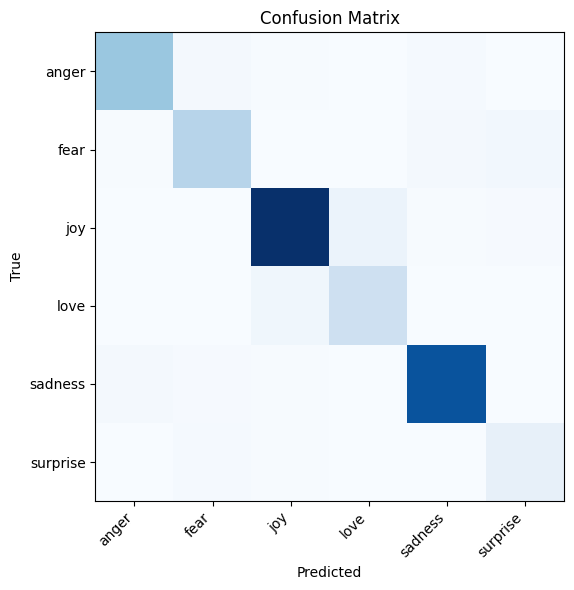

In [ ]:
best_mdl=tf.keras.models.load_model(best_pth)

pred_probs=best_mdl.predict(test_ds)
preds=np.argmax(pred_probs,axis=1)

test_acc=(preds==y_test).mean()
print(f"Test accuracy: {test_acc:.4f}")

print(classification_report(y_test,preds,target_names=[id_to_lbl[i] for i in range(len(id_to_lbl))]))

cm=confusion_matrix(y_test,preds)
fig,ax=plt.subplots(figsize=(6,6))
ax.imshow(cm,cmap="Blues")
ax.set_xticks(range(len(id_to_lbl)))
ax.set_yticks(range(len(id_to_lbl)))
ax.set_xticklabels([id_to_lbl[i] for i in range(len(id_to_lbl))],rotation=45,ha="right")
ax.set_yticklabels([id_to_lbl[i] for i in range(len(id_to_lbl))])
ax.set_xlabel("Predicted")
ax.set_ylabel("True")
ax.set_title("Confusion Matrix")
plt.tight_layout()
plt.show()